# 필요한 라이브러리

In [1]:
import os                       # 파일 경로 계산
import cv2                      # 이미지 파일  관리
import matplotlib.pyplot as plt # 이미지 표시
import numpy as np              # 이미지 데이터 관리
from numpy.linalg import norm   # 이미지 회전 각 계산
import dlib                     # 얼굴 인식, 얼굴 랜드마크 알고리즘

# 이미지 불러오기

In [2]:
# 이미지 디렉토리
image_dir = os.getenv('HOME') + '/aiffel/camera_sticker/images/'
# 모델 디렉토리
model_dir = os.getenv('HOME') + '/aiffel/camera_sticker/models/'

# 스티커를 붙일 사진 파일
my_image_path = os.path.join(image_dir, 'how_i_met_your_mother.png')

img_bgr = cv2.imread(my_image_path)                # 사진 불러오기
img_src = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR 형식을 RGB 형식으로 변환

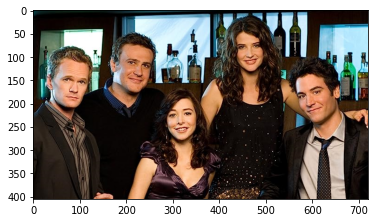

In [3]:
# 불러온 사진 표시
plt.imshow(img_src)
plt.show()

# 모델 불러오기

In [4]:
# 얼굴 인식 알고리즘
detector_hog = dlib.get_frontal_face_detector()

# 얼굴 랜드마크 알고리즘
model_path = os.path.join(model_dir, 'shape_predictor_68_face_landmarks.dat') # 모델 파라미터 파일
landmark_predictor = dlib.shape_predictor(model_path)

# 얼굴 인식

## 함수 정의

In [5]:
# 얼굴 bounding box 찾기
def detect_face(detector, img, num_pyramid_layer=1):
    dlib_rects = detector(img, num_pyramid_layer)
    return dlib_rects


# 얼굴 bounding box 그리기
def draw_face_bbox(img, rects, color=(0, 255, 0), line_width=2):
    for rect in rects:
        # bounding box 좌표값 가져오기
        l = rect.left()
        t = rect.top()
        r = rect.right()
        b = rect.bottom()
        
        # bounding box를 img에 그리기
        cv2.rectangle(img, (l,t), (r,b), color, line_width, lineType=cv2.LINE_AA)
    
    return img

## 얼굴 탐지

In [6]:
img_res = img_src.copy() # 원본 이미지를 유지하기 위해 복사

# 이미지에서 얼굴 bound box 구하기
dlib_rects = detect_face(detector_hog, img_res)

## 얼굴 탐지 결과
띄우고 싶지 않다면 생략하기

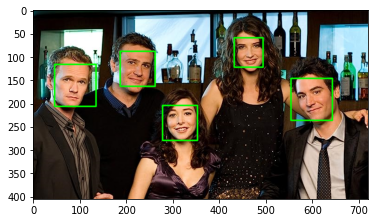

In [7]:
# 탐지된 얼굴 확인하기
img_res = draw_face_bbox(img_res, dlib_rects)

plt.imshow(img_res)
plt.show()

# 얼굴 랜드마크

## 함수 정의

In [8]:
# 얼굴별 랜드마크 찾기
def get_face_landmarks(predictor, img, rects):
    list_landmarks = [] # 각 얼굴의 랜드마크 리스트
    
    for rect in rects:
        # 얼굴 bounding box 내 얼굴 랜드마크 찾기
        points = predictor(img, rect)
        
        # 각 랜드마크 위치를 튜플로 변환
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        
        # 리스트에 저장
        list_landmarks.append(list_points)
    
    return list_landmarks


# 얼굴별 랜드마크 그리기
def draw_face_landmarks(img, list_landmarks, point_size=2, color=(0, 255, 255)):
    # 각 얼굴마다 반복
    for landmark in list_landmarks:
        # 각 랜드마크마다 반복
        for i, point in enumerate(landmark):
            # 특정 랜드마크에 다른 색 지정
            if i == 30:
                color_ = (255, 0, 0)
            elif i == 33:
                color_ = (0, 0, 255)
            else:
                color_ = color
                
            # 해당 랜드마크에 점 그리기
            cv2.circle(img, point, point_size, color_, -1)
    
    return img

## 얼굴 랜드마크 구하기

In [9]:
# bounding box내에서 얼굴 랜드마크 구하기
list_landmarks = get_face_landmarks(landmark_predictor, img_res, dlib_rects)

## 얼굴 랜드마크 탐지 결과
띄우고 싶지 않다면 생략하기

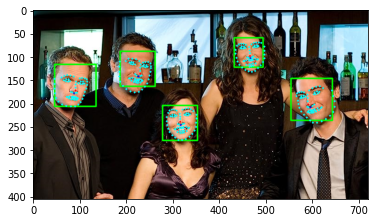

In [10]:
# 얼굴 랜드마크 확인하기
img_res = draw_face_landmarks(img_res, list_landmarks)

plt.imshow(img_res)
plt.show()

# 얼굴에 스티커 붙이기
- 스티커 이미지 색반전
    - 이미지를 회전하면 생기는 빈 부분을 없애기 위함
        - 이미지를 회전하면 남는 부분은 검은색이 됨
        - 스티커 이미지는 배경이 흰색
        - 스티커 이미지를 반전시켜 배경 색을 검은색으로 맞추면 원래 배경과 회전으로 남는 부분이 합쳐진다

In [11]:
# 얼굴에 붙일 스티커 경로
sticker_path = os.path.join(image_dir, 'cat-whiskers.png')

# 스티커 이미지 원본 데이터
img_sticker_src = cv2.imread(sticker_path)

In [12]:
def attach_sticker(img, img_sticker_src, rects, list_landmarks):
    if len(rects) != len(list_landmarks):
        print("인식한 얼굴 수와 랜드마크가 지정된 얼굴 수가 다름")
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        # 얼굴이 회전한 각도를 계산
        nose_horizontal = (landmark[35][0] - landmark[31][0],           # 코의 수평선 벡터 
                           landmark[35][1] - landmark[31][1])
        cos_ = np.dot((1,0), nose_horizontal) / (norm(nose_horizontal)) # x축과 수평선 사이의 코사인 계산
        theta = np.arccos(cos_) / np.pi * 180                           # 두 선 사이의 각도 계산
        
        # 코의 수평선 벡터 방향에 맞춰 회전 방향 변경
        if nose_horizontal[1] > 0:
            theta = -theta
        
        # 스티커의 중심점 위치와 크기 지정
        x = landmark[30][0]
        y = landmark[30][1] + dlib_rect.height() // 2
        w = h = dlib_rect.width()

        # 원본 스터커 이미지를 복사
        img_sticker = img_sticker_src.copy()
        
        # 스티커 이미지를 사용자 얼굴에 맞춰 크기 조정
        img_sticker = cv2.resize(img_sticker, (w, h))

        # 스티커 이미지 회전
        img_sticker = 255 - img_sticker                                   # 스티커 이미지 색반전
        M_rotate = cv2.getRotationMatrix2D((w // 2, h // 2), theta, 1.0 ) # 회전 행렬 구하기
        img_sticker = cv2.warpAffine(img_sticker, M_rotate, (w, h))       # 스티커에 회전 행렬 적용
        img_sticker = 255 - img_sticker                                   # 스티커 이미지 다시 색반전
        
        # 스티커 배치를 위해 스티커의 죄상단이 위치할 좌표 계산
        refined_x = x - w // 2
        refined_y = y - h

        # 좌상단이 인물 이미지 밖인 경우 스티커 이미지를 자르기
        if refined_x < 0:
            img_sticker = img_sticker[:, -refined_x:] # 밖에 나온 영역만큼 자르기
            refined_x = 0                             # 좌표를 최솟값에 맞추기

        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:, :]
            refined_y = 0

        # 스티커가 붙을 영역의 좌표 범위 구하기
        x_min = refined_x
        x_max = refined_x + img_sticker.shape[1]
        y_min = refined_y
        y_max = refined_y + img_sticker.shape[0]
            
        # 스티커가 붙을 영역을 가져오기
        sticker_area = img[y_min:y_max, x_min:x_max]

        # 스티커 이미지의 배경을 자르고 인물 이미지에 오버레이
        # 스티커의 흰 배경은 인물 이미지를 넣기
        img[y_min:y_max, x_min:x_max] = \
            np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
    
    return img

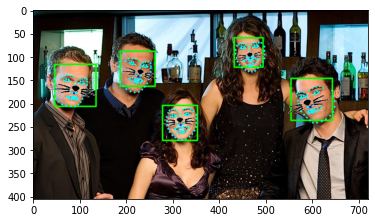

In [13]:
# 스티커 붙인 이미지 띄우기
img_res = attach_sticker(img_res, img_sticker_src, dlib_rects, list_landmarks)

plt.imshow(img_res)
plt.show()

# 최종 결과

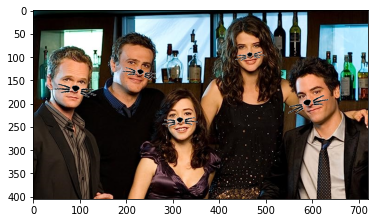

In [14]:
img_res = img_src.copy()

img_res = attach_sticker(img_res, img_sticker_src, dlib_rects, list_landmarks)

plt.imshow(img_res)
plt.show()